### Kickstarter projects success prediction model using neural networks

In [1]:
# libraries required
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split

#### Data collection

In [2]:
df = pd.read_csv('ks-projects-201801.csv')

In [3]:
df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


### Data Exploration and Preprocessing

In [5]:
len(df['country'].value_counts())

23

In [6]:
# dropping columns not relevant to our problem and target leakage features
df.drop(['ID','name','goal','pledged','backers','usd pledged','usd_pledged_real'], axis=1, inplace=True)

In [7]:
# data type transformation of columns deadline and launched
df['deadline'] = pd.to_datetime(df['deadline'])

df['launched'], timestamp = df['launched'].str.split(' ', 1).str
df['launched'] = pd.to_datetime(df['launched'])

<ipython-input-7-e6d77b5c0548>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['launched'], timestamp = df['launched'].str.split(' ', 1).str


In [8]:
df['deadline_month'] = df['deadline'].dt.month
df['launched_month'] = df['launched'].dt.month

In [9]:
df.drop(['deadline', 'launched'], axis=1, inplace=True)

In [10]:
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [11]:
state = []
for i in df['state']:
    if (i == 'failed') or (i == 'successful'):
        new_i = i
    else:
        new_i = 0
    state.append(new_i)
    
df['n_state'] = state

In [12]:
df.drop((df[df['n_state'] == 0]['n_state']).index.tolist(), inplace=True)

In [13]:
df.drop('n_state', axis=1, inplace=True)

In [14]:
df['country'].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

In [15]:
df['country'].replace('N,0"', np.nan, inplace=True)

In [16]:
df.dropna(inplace=True)

In [ ]:
# balance the data - response variable
# log transform - usd_goal_real
# PCA - data

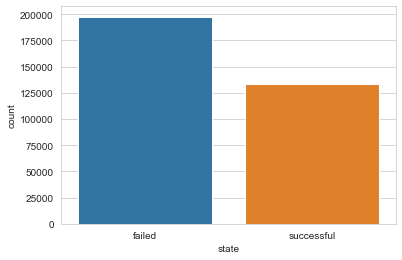

In [18]:
sns.countplot(df['state'])

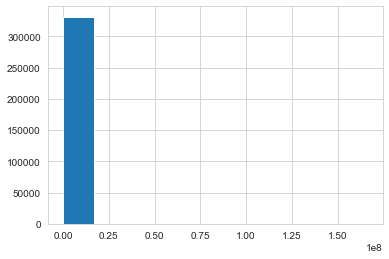

In [19]:
df['usd_goal_real'].hist()

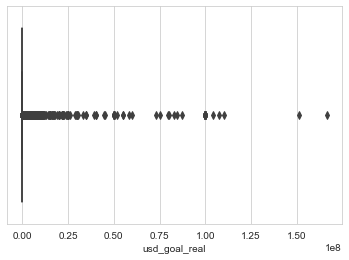

In [20]:
sns.boxplot(df['usd_goal_real'])

In [21]:
# interquartile range of the usd_goal_real column

sort_goal = np.sort(df['usd_goal_real'])

q1 = np.percentile(sort_goal, 25, interpolation = 'midpoint')
print(q1)
q2 = np.percentile(sort_goal, 50, interpolation = 'midpoint')
print(q2)
q3 = np.percentile(sort_goal, 75, interpolation = 'midpoint')
print(q3)

IQR = q3-q1
print(IQR)

2000.0
5000.0
15000.0
13000.0


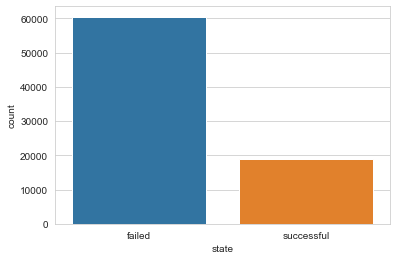

In [22]:
sns.countplot(df[df['usd_goal_real'] > 15000]['state'])

In [23]:
# target column
df['state'].replace('failed', 0, inplace=True)
df['state'].replace('successful', 1, inplace=True)

In [24]:
df.head()

,category,main_category,currency,state,country,usd_goal_real,deadline_month,launched_month
0,Poetry,Publishing,GBP,0,GB,1533.95,10,8
1,Narrative Film,Film & Video,USD,0,US,30000.00,11,9
2,Narrative Film,Film & Video,USD,0,US,45000.00,2,1
3,Music,Music,USD,0,US,5000.00,4,3
5,Restaurants,Food,USD,1,US,50000.00,4,2


In [25]:
data = pd.get_dummies(df, columns = ['main_category','category', 'currency', 'country'])

In [26]:
data.head()

,state,usd_goal_real,deadline_month,launched_month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,1533.95,10,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30000.00,11,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,50000.00,4,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
# train test split
X = data.drop('state', axis=1)
y = data['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

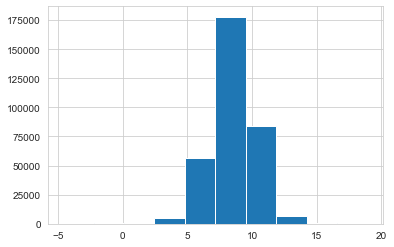

In [28]:
(np.log(df['usd_goal_real'])).hist()

In [29]:
X_train['usd_goal'] = np.log(X_train['usd_goal_real'])

<ipython-input-29-e19f5ebbedda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['usd_goal'] = np.log(X_train['usd_goal_real'])


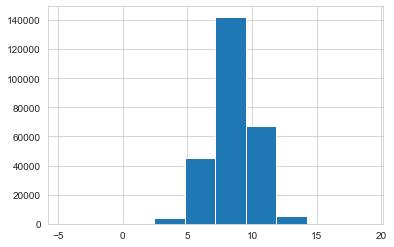

In [30]:
X_train['usd_goal'].hist()

In [31]:
X_train.drop('usd_goal_real', axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Model training

In [32]:
from keras.models import Sequential
from keras.layers import Dense

In [44]:
# define the keras model
model = Sequential()
model.add(Dense(30, input_dim=213, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [45]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=100, batch_size=100)

Epoch 1/100
2652/2652 [==============================] - 7s 3ms/step - loss: 0.6073 - accuracy: 0.6636
Epoch 2/100
2652/2652 [==============================] - 8s 3ms/step - loss: 0.5997 - accuracy: 0.6694
Epoch 3/100
2652/2652 [==============================] - 8s 3ms/step - loss: 0.5966 - accuracy: 0.6728
Epoch 4/100
2652/2652 [==============================] - 7s 3ms/step - loss: 0.5947 - accuracy: 0.6742
Epoch 5/100
2652/2652 [==============================] - 7s 3ms/step - loss: 0.5935 - accuracy: 0.6755
Epoch 6/100
2652/2652 [==============================] - 7s 3ms/step - loss: 0.5927 - accuracy: 0.6755
Epoch 7/100
2652/2652 [==============================] - 7s 3ms/step - loss: 0.5919 - accuracy: 0.6763
Epoch 8/100
2652/2652 [==============================] - 6s 2ms/step - loss: 0.5910 - accuracy: 0.6764
Epoch 9/100
2652/2652 [==============================] - 7s 2ms/step - loss: 0.5904 - accuracy: 0.6774
Epoch 10/100
2652/2652 [==============================] - 7s 2ms/step - l

In [28]:
X_test['usd_goal'] = np.log(X_test['usd_goal_real'])

<ipython-input-28-12a9549d3369>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['usd_goal'] = np.log(X_test['usd_goal_real'])


In [29]:
X_test.drop('usd_goal_real', axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Model Evaluation

In [34]:
pred = model.predict(X_test)
pred

In [36]:
a = []
for i in pred:
    if (i > 0.5):
        new_i = 1
    elif (i <= 0.5):
        new_i = 0
    a.append(new_i)

pred = a

In [37]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74     39577
           1       0.61      0.49      0.55     26716

    accuracy                           0.67     66293
   macro avg       0.66      0.64      0.64     66293
weighted avg       0.66      0.67      0.66     66293

[[31331  8246]
 [13560 13156]]


In [33]:
from tensorflow.keras.layers import LSTM

In [34]:
X_train.shape

(265172, 213)

In [35]:
X_train = np.array(X_train)
X_test = np.array(X_test)

# reshaping the data to make it compatible with the LSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [36]:
X_train.shape

(265172, 213, 1)

In [ ]:
# 50,50,25,1 - 6912
# 10,50,50,2 - didn't work well(around 50)

In [ ]:
### adding an LSTM layer

In [37]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (213, 1)))
#model.add(LSTM(60, return_sequences = True))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [43]:
#model.fit(X_train, y_train, epochs=100, batch_size=100)